# Data Grouping and Aggregation with Pandas groupby()

In [2]:
# Loading dataset
import warnings
warnings.filterwarnings('ignore')

# Data setup (Titanic Dataset)
import pandas as pd
import numpy as np

np.random.seed(42)
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
print(df.shape)
print(df.head(3))

(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


# 📊 1. Basic Grouping Operations
## Example 1: Basic Single-Column Grouping

In [3]:
# Survival rate by passenger class
survival_by_class = df.groupby('Pclass')['Survived'].mean()
print("Survival Rate by Class:")
print(survival_by_class)
print("\n" + "="*50)

# Count passengers by embarkation point
embarkation_counts = df.groupby('Embarked').size()
print("\nPassengers by Embarkation Point:")
print(embarkation_counts)

Survival Rate by Class:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


Passengers by Embarkation Point:
Embarked
C    168
Q     77
S    644
dtype: int64


# 📈 2. Multiple Aggregations on Single Column
## Example 2: Comprehensive Age Analysis by Gender

In [4]:
age_analysis = df.groupby('Sex')['Age'].agg([
    ('count', 'count'),
    ('mean_age', 'mean'),
    ('median_age', 'median'),
    ('min_age', 'min'),
    ('max_age', 'max'),
    ('age_std', 'std'),
    ('age_range', lambda x: x.max() - x.min())
]).round(2)

print("Age Statistics by Gender:")
print(age_analysis)

Age Statistics by Gender:
        count  mean_age  median_age  min_age  max_age  age_std  age_range
Sex                                                                      
female    261     27.92        27.0     0.75     63.0    14.11      62.25
male      453     30.73        29.0     0.42     80.0    14.68      79.58


# 🔄 3. Grouping by Multiple Columns
## Example 3: Survival Analysis by Class and Gender

In [5]:
# Two-level grouping for deeper insights
class_gender_survival = df.groupby(['Pclass', 'Sex']).agg({
    'Survived': ['count', 'sum', 'mean'],
    'Fare': ['mean', 'median', 'max'],
    'Age': 'mean'
}).round(3)

# Flatten multi-level columns
class_gender_survival.columns = [
    'total_passengers', 'survivors', 'survival_rate',
    'avg_fare', 'median_fare', 'max_fare', 'avg_age'
]

print("Survival Analysis by Class and Gender:")
print(class_gender_survival)

Survival Analysis by Class and Gender:
               total_passengers  survivors  survival_rate  avg_fare  \
Pclass Sex                                                            
1      female                94         91          0.968   106.126   
       male                 122         45          0.369    67.226   
2      female                76         70          0.921    21.970   
       male                 108         17          0.157    19.742   
3      female               144         72          0.500    16.119   
       male                 347         47          0.135    12.662   

               median_fare  max_fare  avg_age  
Pclass Sex                                     
1      female       82.665   512.329   34.612  
       male         41.262   512.329   41.281  
2      female       22.000    65.000   28.723  
       male         13.000    73.500   30.741  
3      female       12.475    69.550   21.750  
       male          7.925    69.550   26.508  


# 🎯 4. Answering Specific Business Questions
## Question 1: "What was the family size impact on survival?"

In [6]:
# Create family size category
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['FamilyCategory'] = pd.cut(df['FamilySize'], 
                              bins=[0, 1, 4, 11],
                              labels=['Alone', 'Small Family', 'Large Family'])

family_survival = df.groupby('FamilyCategory').agg({
    'Survived': ['count', 'mean'],
    'Fare': 'mean',
    'Age': 'mean'
}).round(3)

print("Survival by Family Size:")
print(family_survival)

Survival by Family Size:
               Survived           Fare     Age
                  count   mean    mean    mean
FamilyCategory                                
Alone               537  0.304  21.243  32.220
Small Family        292  0.579  46.824  28.101
Large Family         62  0.161  58.290  17.843


# Question 2: "Was there a 'women and children first' policy?"

In [7]:
# Create age and gender segments
def categorize_passenger(row):
    if pd.isna(row['Age']):
        return 'Unknown'
    elif row['Age'] < 18:
        return 'Child'
    elif row['Sex'] == 'female':
        return 'Adult Female'
    else:
        return 'Adult Male'

df['PassengerCategory'] = df.apply(categorize_passenger, axis=1)

policy_analysis = df.groupby('PassengerCategory').agg({
    'Survived': ['count', 'mean'],
    'Pclass': lambda x: (x == 1).mean()  # % in first class
}).round(3)

print("'Women and Children First' Analysis:")
print(policy_analysis)

'Women and Children First' Analysis:
                  Survived          Pclass
                     count   mean <lambda>
PassengerCategory                         
Adult Female           206  0.772    0.374
Adult Male             395  0.177    0.246
Child                  113  0.540    0.106
Unknown                177  0.294    0.169


# 📊 5. Advanced Aggregation Techniques
## Example 4: Custom Aggregation Functions

In [12]:
# Define custom aggregation functions PROPERLY

# Function 1: Survival rate as percentage string
def survival_rate(series):
    """Convert survival rate to percentage string"""
    return f"{series.mean() * 100:.1f}%"

# Function 2: Gini coefficient for wealth concentration
def gini_coefficient(series):
    """Calculate Gini coefficient for wealth inequality"""
    # Remove NaN values
    fares = series.dropna()
    if len(fares) == 0:
        return 0
    
    # Sort values
    sorted_fares = np.sort(fares)
    n = len(sorted_fares)
    
    # Gini coefficient formula
    cumsum = np.cumsum(sorted_fares)
    numerator = np.sum((2 * np.arange(1, n + 1) - n - 1) * sorted_fares)
    denominator = n * np.sum(sorted_fares)
    
    return numerator / denominator if denominator != 0 else 0

# Function 3: Fare per survivor (needs different approach - see below)
def fare_stats(series):
    """Return multiple statistics in a Series"""
    return pd.Series({
        'mean': series.mean(),
        'median': series.median(),
        'std': series.std(),
        'gini': gini_coefficient(series)
    })

# Function 4: Age diversity index
def age_diversity(series):
    """Measure of age spread (coefficient of variation)"""
    if len(series.dropna()) == 0:
        return 0
    std = series.std()
    mean = series.mean()
    return std / mean if mean != 0 else 0

# Apply custom aggregations CORRECTLY
import numpy as np

advanced_analysis = df.groupby('Pclass').agg({
    'Survived': ['count', 'sum', survival_rate],
    'Fare': ['mean', 'std', 'median', gini_coefficient],
    'Age': ['mean', 'median', age_diversity],
    'PassengerId': 'nunique'
}).round(3)

print("Advanced Class Analysis:")
print(advanced_analysis)

Advanced Class Analysis:
       Survived                       Fare                                   \
          count  sum survival_rate    mean     std  median gini_coefficient   
Pclass                                                                        
1           216  136         63.0%  84.155  78.380  60.287            0.424   
2           184   87         47.3%  20.662  13.417  14.250            0.311   
3           491  119         24.2%  13.676  11.778   8.050            0.358   

           Age                      PassengerId  
          mean median age_diversity     nunique  
Pclass                                           
1       38.233   37.0         0.387         216  
2       29.878   29.0         0.469         184  
3       25.141   24.0         0.497         491  


# 🔄 6. Time-Series Like Grouping (by Age Groups)
## Example 5: Age Cohort Analysis

In [9]:
# Create age cohorts
age_bins = [0, 12, 18, 30, 50, 80]
age_labels = ['Child', 'Teen', 'Young Adult', 'Middle Aged', 'Senior']
df['AgeCohort'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

cohort_analysis = df.groupby('AgeCohort').agg({
    'Survived': ['count', 'mean'],
    'Pclass': lambda x: (x == 1).mean(),  # % in first class
    'Fare': 'median',
    'SibSp': 'mean'  # Average siblings/spouses
}).round(3)

print("Age Cohort Analysis:")
print(cohort_analysis)

Age Cohort Analysis:
            Survived          Pclass    Fare  SibSp
               count   mean <lambda>  median   mean
AgeCohort                                          
Child             69  0.580    0.058  27.750  1.870
Teen              70  0.429    0.171  11.500  0.657
Young Adult      270  0.356    0.167  10.500  0.315
Middle Aged      241  0.423    0.357  24.150  0.373
Senior            64  0.344    0.609  28.125  0.250


# 📈 7. Pivot Table Style Grouping
## Example 6: Multi-dimensional Analysis

In [13]:
# Create a pivot-like analysis
# Create separate analyses and combine
survival_counts = df.pivot_table(
    index='Pclass', columns='Sex', values='Survived',
    aggfunc='count', margins=True, margins_name='Total'
).rename(columns=lambda x: f"{x}_count")

survival_rates = df.pivot_table(
    index='Pclass', columns='Sex', values='Survived',
    aggfunc='mean', margins=True, margins_name='Total'
).rename(columns=lambda x: f"{x}_rate")

avg_fares = df.pivot_table(
    index='Pclass', columns='Sex', values='Fare',
    aggfunc='mean', margins=True, margins_name='Total'
).rename(columns=lambda x: f"{x}_avg_fare")

# Combine horizontally
combined_analysis = pd.concat(
    [survival_counts, survival_rates, avg_fares],
    axis=1
).round(3)

# Reorder columns for better readability
column_order = []
for gender in ['female', 'male', 'Total']:
    column_order.extend([f"{gender}_count", f"{gender}_rate", f"{gender}_avg_fare"])

combined_analysis = combined_analysis[column_order]

print("Combined Multi-dimensional Analysis:")
print(combined_analysis)

Combined Multi-dimensional Analysis:
Sex     female_count  female_rate  female_avg_fare  male_count  male_rate  \
Pclass                                                                      
1                 94        0.968          106.126         122      0.369   
2                 76        0.921           21.970         108      0.157   
3                144        0.500           16.119         347      0.135   
Total            314        0.742           44.480         577      0.189   

Sex     male_avg_fare  Total_count  Total_rate  Total_avg_fare  
Pclass                                                          
1              67.226          216       0.630          84.155  
2              19.742          184       0.473          20.662  
3              12.662          491       0.242          13.676  
Total          25.524          891       0.384          32.204  


# 🎨 8. Visualization with Grouped Data

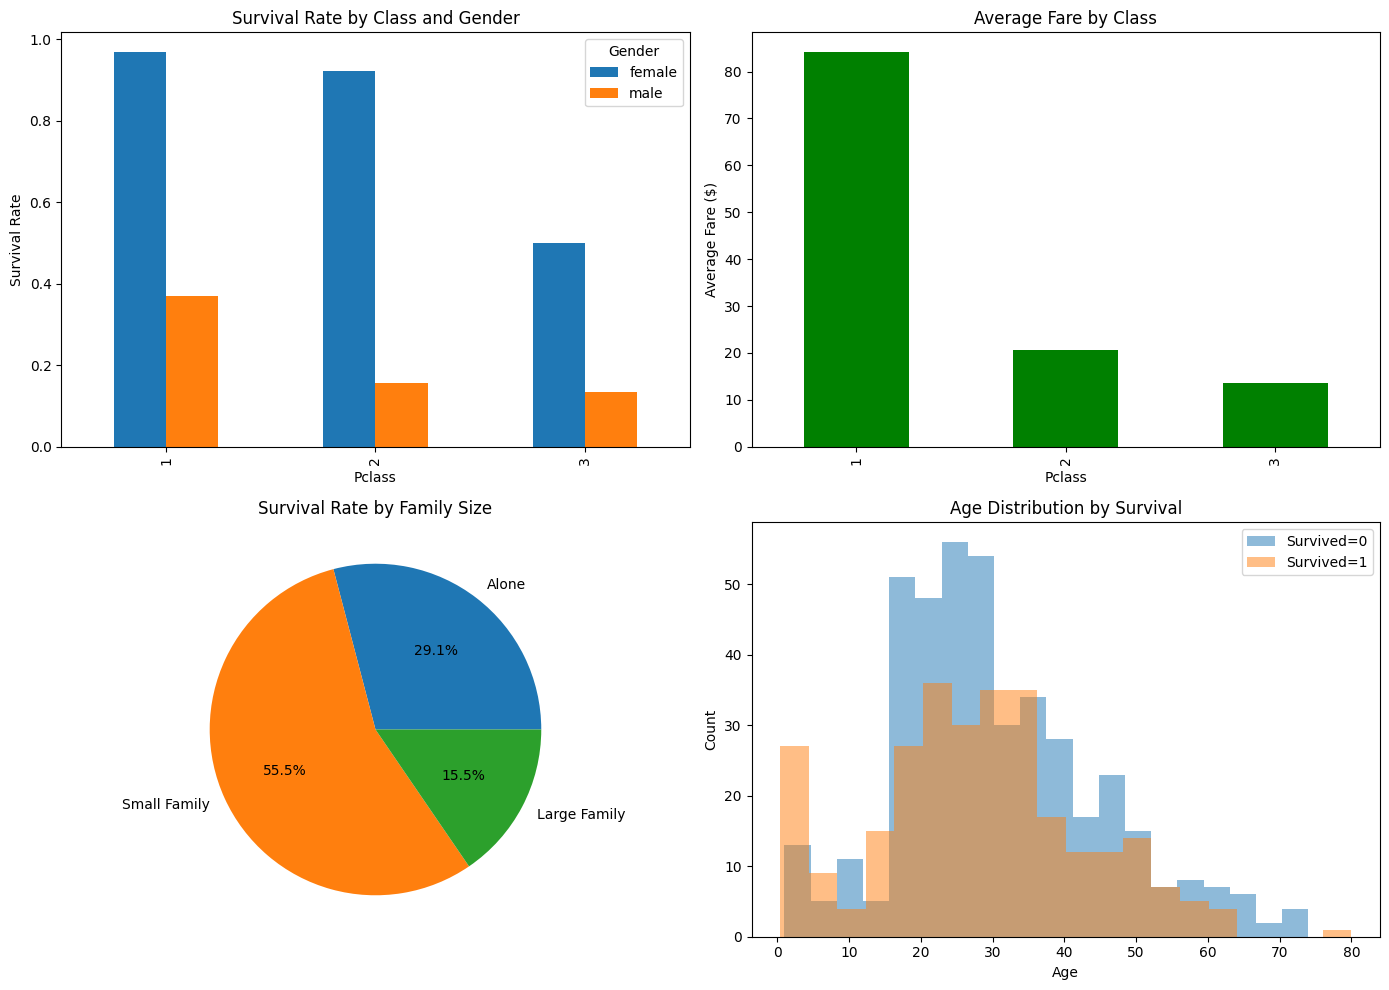

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
survival_by_class_gender = df.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Survival rate by class and gender
survival_by_class_gender.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Survival Rate by Class and Gender')
axes[0, 0].set_ylabel('Survival Rate')
axes[0, 0].legend(title='Gender')

# 2. Average fare by class
df.groupby('Pclass')['Fare'].mean().plot(kind='bar', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Average Fare by Class')
axes[0, 1].set_ylabel('Average Fare ($)')

# 3. Family size impact
df.groupby('FamilyCategory')['Survived'].mean().plot(kind='pie', ax=axes[1, 0], autopct='%1.1f%%')
axes[1, 0].set_title('Survival Rate by Family Size')
axes[1, 0].set_ylabel('')

# 4. Age distribution by survival
for survived in [0, 1]:
    subset = df[df['Survived'] == survived]['Age'].dropna()
    axes[1, 1].hist(subset, bins=20, alpha=0.5, label=f"Survived={survived}")
axes[1, 1].set_title('Age Distribution by Survival')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()